In [1]:
import os, sys
import pytorch_lightning as pl
import torch
from rdkit import Chem
import numpy as np
import rdkit.Chem.Descriptors
from IPython.display import Image, display
from rdkit.Chem import PandasTools
import matplotlib.pyplot as plt
import torch_geometric

%load_ext tensorboard

In [2]:
if "../../.." not in sys.path:
    sys.path.append("../../..")

In [3]:
DEFAULT_DPI=300
DEFAULT_IMG_PLOT_WIDTH=400
SEED=2
TEST_SMILES="COc1ccc([N+](=O)[O-])cc1"
DEFAULT_PATIENCE=5

In [4]:
def plot_true_pred(model,loader,target_file=None):
    true=[]
    pred=[]
    for i,d in enumerate(loader.test_dataloader()):
        pred.extend(model(d.to(model.device)).detach().cpu().numpy()[:,0])
        true.extend(d.y.detach().cpu().numpy()[:,0])
        
        
    plt.plot(true,pred,"o")
    if target_file is None:
        plt.show()
    else:
        os.makedirs(os.path.dirname(target_file),exist_ok=True)
        plt.savefig(target_file,dpi=DEFAULT_DPI)
    plt.close()

In [5]:
from IPython.display import clear_output
class ClearCallback(pl.Callback):
    def on_epoch_end(self,*args,**kwargs):
        self.clear()
    
    def clear(self):
        clear_output(wait=True)
    
class StoreMetricsCallback(pl.Callback):
    def __init__(self,live_plot=True,final_save=None,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.data={}
        self.live_plot=live_plot
        self.final_save=final_save
    
    def plot_data(self,save=None):
        plt.figure()
        for label,data in self.data.items():
            plt.plot(data[0],data[1], label=label)
        plt.legend()
        if save:
            plt.savefig(save,dpi=DEFAULT_DPI)
        else:
            plt.show()
        plt.close()
        
    def on_validation_epoch_end(self,trainer, pl_module,*args,**kwargs):
        ep=trainer.current_epoch
        for k,v in trainer.callback_metrics.items():
            if k not in self.data:
                self.data[k]=([],[])
            self.data[k][0].append(ep)
            self.data[k][1].append(v.detach().cpu().numpy())
        if self.live_plot:
            self.plot_data()
            
            

    #on_validation_epoch_end = on_epoch_end
    #on_test_epoch_end = on_epoch_end
    #on_train_epoch_end = on_epoch_end
    
    def on_train_end(self,trainer, pl_module):
        self.plot_data(self.final_save)

In [23]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

def default_model_run(model_name,model,loader,force_run=False,detect_lr=True,show_tb=True,
                      train=True,save=True,test=True,live_plot=True,max_epochs=1000,min_epochs=1):
    model_dir=os.path.join("models",model_name)

    logdir=os.path.join(model_dir,"logs")
    tb_logdir=os.path.join(logdir,"tensorboard")
    plot_dir=os.path.join(model_dir,"plots")
    
    os.makedirs(plot_dir,exist_ok=True)
    true_pred_plt=os.path.join(plot_dir,"tvp.png")
    lr_optim_plot=os.path.join(plot_dir,"lrp.png")
    metrics_plot=os.path.join(plot_dir,"metrics.png")
    
    model_checkpoint=os.path.join(model_dir,"model.ckpt")
    
    if not force_run:
        try:
            model = model.__class__.load_from_checkpoint(model_checkpoint,map_location=lambda storage, location: storage)
        except:
            force_run=True
    
    if force_run:
        
        loader.setup()
        
        if detect_lr:
            lr_trainer = pl.Trainer()
            lr_finder = lr_trainer.tuner.lr_find(model,train_dataloader=loader.train_dataloader(),max_lr=10**2)
            fig = lr_finder.plot(suggest=True)
            
            plt.savefig(lr_optim_plot,dpi=DEFAULT_DPI)
            plt.close()
            # Pick point based on plot, or get suggestion
            model.lr = lr_finder.suggestion()
            print("set lr to",model.lr)
    
        if train or test:
            clear_cb=ClearCallback()
            tb_logger = TensorBoardLogger(tb_logdir)
            checkpoint_callback = ModelCheckpoint(monitor='val_loss')
            metrics_cb = StoreMetricsCallback(live_plot=live_plot,
                                 final_save=metrics_plot,
                                 )
            trainer = pl.Trainer(max_epochs=max_epochs,gpus=torch.cuda.device_count(),
                                callbacks=[
                                    clear_cb,
                                    pl.callbacks.early_stopping.EarlyStopping(monitor='val_loss',patience=DEFAULT_PATIENCE),
                                    metrics_cb,
                                    checkpoint_callback,
                                ],
                                logger=tb_logger,
                                terminate_on_nan=True,
                                 min_epochs=min_epochs,
                                )

        if train:
            trainer.fit(model,loader)
            model = model.__class__.load_from_checkpoint(checkpoint_callback.best_model_path)
            
        if test:
            trainer.test(model=model,ckpt_path=None)
            
        if save:
            trainer.save_checkpoint(model_checkpoint)

        model.to('cpu')
        plot_true_pred(model,loader,target_file=true_pred_plt)
    
    if os.path.exists(lr_optim_plot):
        display(Image(lr_optim_plot, width=DEFAULT_IMG_PLOT_WIDTH))
    if os.path.exists(metrics_plot):
        display(Image(metrics_plot, width=DEFAULT_IMG_PLOT_WIDTH))
    if os.path.exists(true_pred_plt):
        display(Image(true_pred_plt, width=DEFAULT_IMG_PLOT_WIDTH))
    
    data={}
    try:
        data["trainer"]=trainer
    except:
        pass
    return model,data

In [7]:
def find_test_data(loader,smiles=None):
    if smiles is None:
        smiles = TEST_SMILES
    loader.setup()
    for subloader in [loader.test_dataloader(),loader.val_dataloader(),loader.train_dataloader()]:
        for i,d in enumerate(subloader):
            for sd in d.to_data_list():
                if smiles == sd.string_data[0][sd.string_data_titles[0].index("smiles")]:
                    return sd
    raise ValueError()

                

In [37]:
#first a blank mol dataset
#from molNet.dataloader.datasets import DelaneySolubility
#dataset=DelaneySolubility().df
import pandas as pd
dataset = pd.read_csv("list_chemicals-2020-12-05-21-46-06.tsv",sep="\t")

TEST_SMILES=Chem.MolToSmiles(Chem.MolFromSmiles(TEST_SMILES))
dataset = dataset.append({
    'SMILES':"C",
    'PREFERRED_NAME':"Methane"
},ignore_index=True)
dataset["rd_mol"] = dataset['SMILES'].apply(lambda s: Chem.MolFromSmiles(s))
no_mols = dataset.index[~dataset["rd_mol"].apply(lambda x: isinstance(x,Chem.Mol))]
dataset.drop(no_mols,inplace=True)
dataset["SMILES"] = dataset['rd_mol'].apply(lambda s: Chem.MolToSmiles(s))
dataset["molar_mass"] = dataset['rd_mol'].apply(lambda mol: Chem.Descriptors.MolWt(mol))
dataset = dataset.rename({'PREFERRED_NAME':'name'},axis=1)


dataset

,DTXSID,name,CASRN,INCHIKEY,IUPAC_NAME,SMILES,INCHI_STRING,MOLECULAR_FORMULA,AVERAGE_MASS,MONOISOTOPIC_MASS,DATA_SOURCES,NUMBER_OF_PUBMED_ARTICLES,PUBCHEM_DATA_SOURCES,CPDAT_COUNT,rd_mol,molar_mass
0,DTXSID7020009,Acetonitrile,75-05-8,WEVYAHXRMPXWCK-UHFFFAOYSA-N,Acetonitrile,CC#N,InChI=1S/C2H3N/c1-2-3/h1H3,C2H3N,41.053,41.026549101,165.0,3174.0,1110,318,"<img data-content=""rdkit/molecule"" src=""data:i...",41.053
1,DTXSID5020023,Acrolein,107-02-8,HGINCPLSRVDWNT-UHFFFAOYSA-N,Prop-2-enal,C=CC=O,"InChI=1S/C3H4O/c1-2-3-4/h2-3H,1H2",C3H4O,56.064,56.026214749,189.0,2468.0,139,30,"<img data-content=""rdkit/molecule"" src=""data:i...",56.064
2,DTXSID0020024,Acrolein diethylacetal,3054-95-3,MCIPQLOKVXSHTD-UHFFFAOYSA-N,"3,3-Diethoxyprop-1-ene",C=CC(OCC)OCC,"InChI=1S/C7H14O2/c1-4-7(8-5-2)9-6-3/h4,7H,1,5-...",C7H14O2,130.187,130.099379691,45.0,1.0,100,-,"<img data-content=""rdkit/molecule"" src=""data:i...",130.187
3,DTXSID5020029,Acrylonitrile,107-13-1,NLHHRLWOUZZQLW-UHFFFAOYSA-N,Prop-2-enenitrile,C=CC#N,"InChI=1S/C3H3N/c1-2-3-4/h2H,1H2",C3H3N,53.064,53.026549101,195.0,1092.0,168,582,"<img data-content=""rdkit/molecule"" src=""data:i...",53.064
4,DTXSID8020044,Allyl alcohol,107-18-6,XXROGKLTLUQVRX-UHFFFAOYSA-N,Prop-2-en-1-ol,C=CCO,"InChI=1S/C3H6O/c1-2-3-4/h2,4H,1,3H2",C3H6O,58.08,58.041864813,153.0,627.0,152,2,"<img data-content=""rdkit/molecule"" src=""data:i...",58.080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3851,DTXSID30996806,(6-Methylheptan-2-yl)hydrazine,7535-34-4,WAYKZORTCXXXDO-UHFFFAOYNA-N,(6-Methylheptan-2-yl)hydrazine,CC(C)CCCC(C)NN,"InChI=1/C8H20N2/c1-7(2)5-4-6-8(3)10-9/h7-8,10H...",C8H20N2,144.262,144.162648652,6.0,-,-,-,"<img data-content=""rdkit/molecule"" src=""data:i...",144.262
3852,DTXSID10998848,2-Chlorooxirane,7763-77-1,WBNCHVFLFSFIGK-UHFFFAOYNA-N,2-Chlorooxirane,ClC1CO1,"InChI=1/C2H3ClO/c3-2-1-4-2/h2H,1H2",C2H3ClO,78.5,77.9872424,6.0,-,-,-,"<img data-content=""rdkit/molecule"" src=""data:i...",78.498
3853,DTXSID20999144,2-[(Butan-2-yl)oxy]ethan-1-ol,7795-91-7,HUWFDQSAXOIUNP-UHFFFAOYNA-N,2-[(Butan-2-yl)oxy]ethan-1-ol,CCC(C)OCCO,"InChI=1/C6H14O2/c1-3-6(2)8-5-4-7/h6-7H,3-5H2,1...",C6H14O2,118.176,118.099379691,11.0,-,-,-,"<img data-content=""rdkit/molecule"" src=""data:i...",118.176
3854,DTXSID70999775,2-Methyl-1-[(propan-2-yl)oxy]propane,78448-33-6,HIIBZFKVMXEQMR-UHFFFAOYSA-N,2-Methyl-1-[(propan-2-yl)oxy]propane,CC(C)COC(C)C,"InChI=1S/C7H16O/c1-6(2)5-8-7(3)4/h6-7H,5H2,1-4H3",C7H16O,116.204,116.120115135,3.0,-,-,-,"<img data-content=""rdkit/molecule"" src=""data:i...",116.204


In [31]:
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds, CalcExactMolWt, CalcNumLipinskiHBD, CalcNumRings, \
    CalcNumLipinskiHBA, CalcNumHBA, CalcNumHBD, CalcNumAromaticRings, CalcNumSaturatedRings, CalcNumHeterocycles, \
    CalcNumAromaticHeterocycles, CalcNumAromaticCarbocycles, CalcNumSaturatedHeterocycles, CalcNumSaturatedCarbocycles, \
    CalcNumAliphaticRings, CalcNumAliphaticHeterocycles, CalcNumAliphaticCarbocycles, CalcNumHeteroatoms, \
    CalcNumAmideBonds, CalcFractionCSP3, CalcLabuteASA, CalcTPSA, CalcChi0v, CalcChi1v, CalcChi2v, CalcChi3v, CalcChi4v, \
    CalcChi0n, CalcChi1n, CalcChi2n, CalcChi3n, CalcChi4n, CalcHallKierAlpha, CalcKappa1, CalcKappa2, CalcKappa3, \
    CalcNumSpiroAtoms, CalcNumBridgeheadAtoms, CalcNumAtomStereoCenters, CalcNumUnspecifiedAtomStereoCenters, CalcPBF, \
    CalcNPR1, CalcNPR2, CalcPMI1, CalcPMI2, CalcPMI3, CalcRadiusOfGyration, CalcInertialShapeFactor, CalcEccentricity, \
    CalcAsphericity, CalcSpherocityIndex, CalcCrippenDescriptors, GetUSR, GetUSRCAT, SlogP_VSA_, SMR_VSA_, PEOE_VSA_, \
    CalcWHIM, CalcGETAWAY, CalcRDF, CalcMORSE, CalcAUTOCORR3D, CalcAUTOCORR2D
sdf=dataset.copy()

sdf=sdf[sdf.rd_mol.apply(lambda mol: CalcNumAromaticRings(mol)>0)]
patern=Chem.MolFromSmarts('[N+]([O-])=O')
sdf=sdf[sdf.rd_mol.apply(lambda mol: mol.HasSubstructMatch(patern))]
patern=Chem.MolFromSmarts('cOC')
sdf=sdf[sdf.rd_mol.apply(lambda mol: mol.HasSubstructMatch(patern))]
m =sdf.iloc[0].rd_mol

TEST_SMILES=Chem.MolToSmiles(sdf.sort_values("molar_mass",axis=0).rd_mol.iloc[0])
TEST_SMILES

'COc1ccccc1[N+](=O)[O-]'

First we start with a simple example by predicting the molar masses of random molecules (**maybe library for creating pseudo random molecules**). As a featurization the mass of each individual atom was used. As a result the model should be trained to simply add all individual atomic masses. 

Thus first we create the model without any graph convolutional layer and as a pooling function sum pooling is used:

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


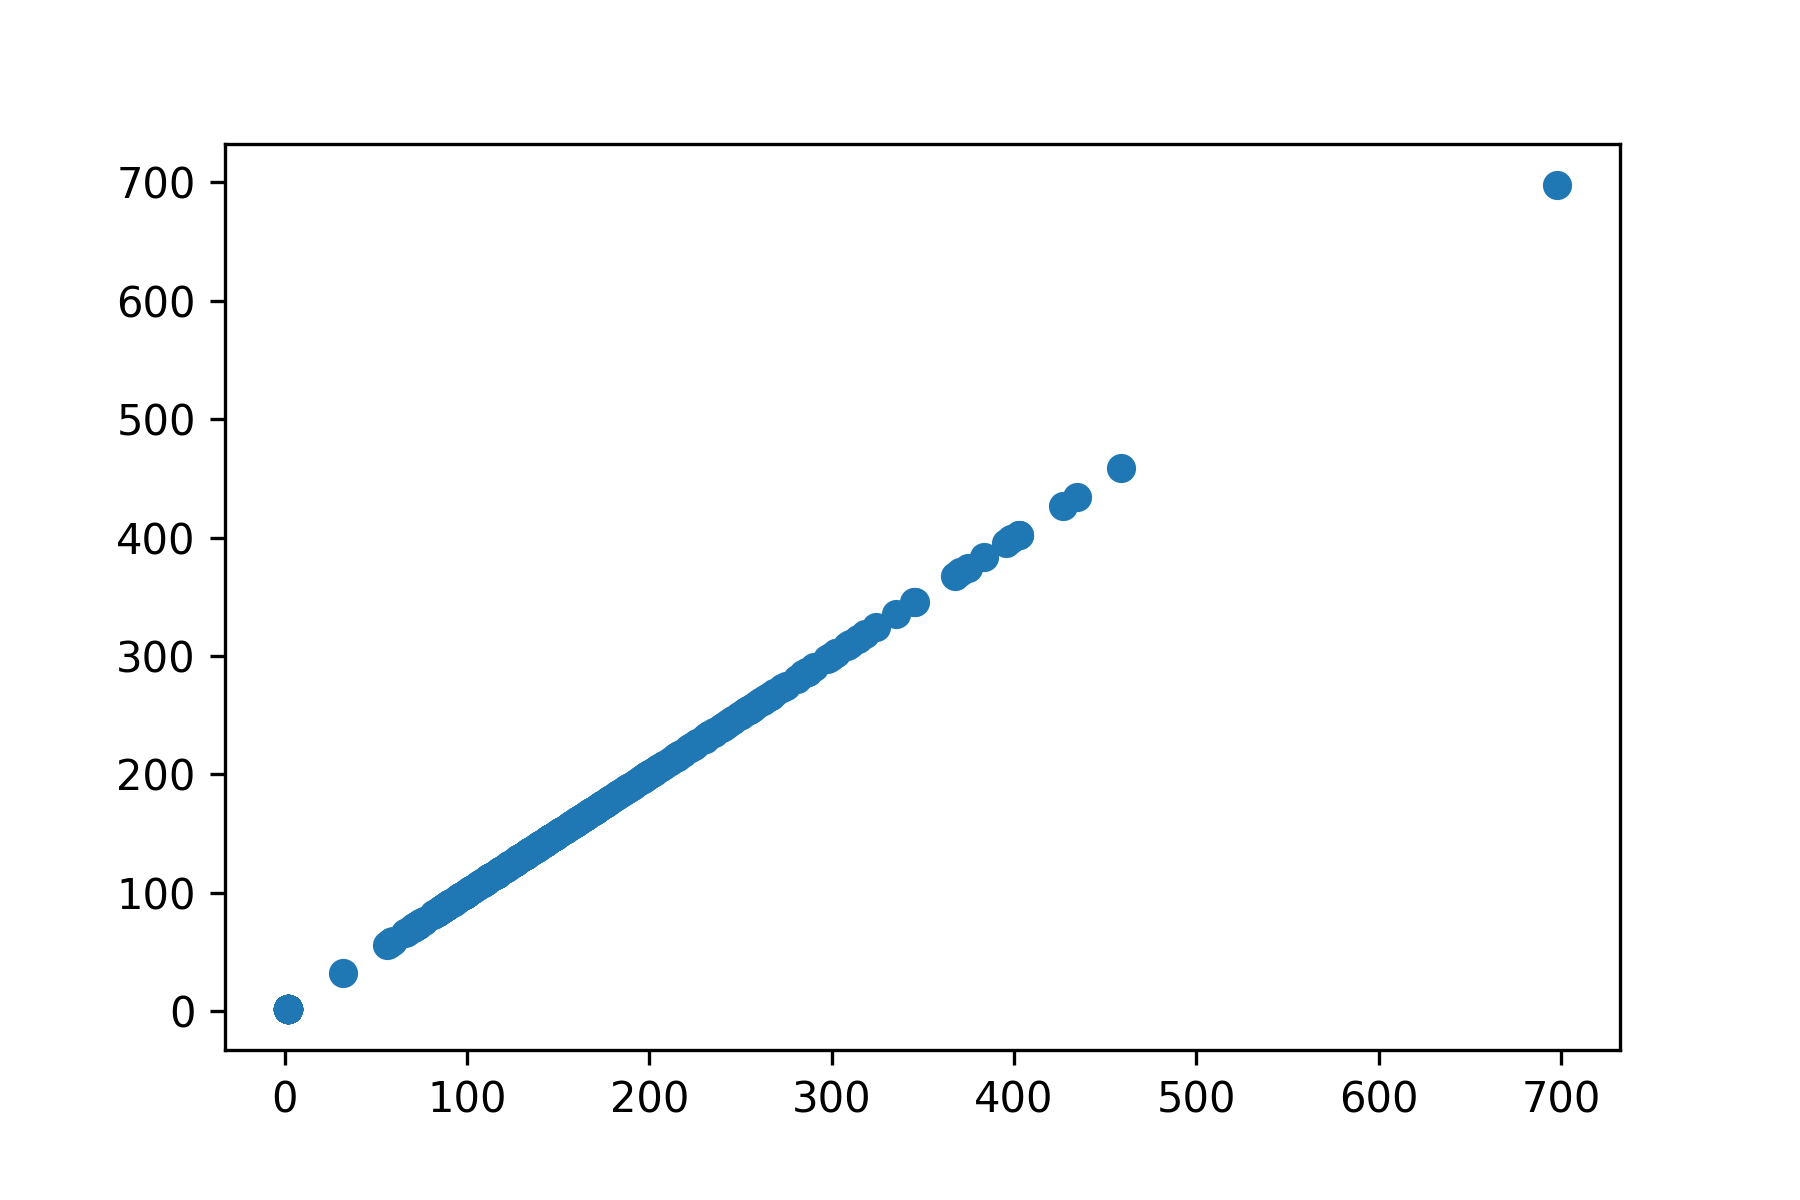

In [10]:
# noinspection JupyterPackage
from molNet.nn.models.graph_convolution import PoolSum
from molNet.dataloader.molecule_loader import PytorchGeomMolGraphFromGeneratorLoader, PytorchGeomMolGraphGenerator, PytorchGeomMolGraphFromDfLoader
from molNet.featurizer.atom_featurizer import atom_mass

class SimpleSumAtomMassesModel(pl.LightningModule):
    def __init__(self,name="none"):
        super().__init__()
        self.save_hyperparameters()
        self.pooling =PoolSum()

    def unpacked_forward(self, feats, edges, batch,graph_features):
        feats = self.pooling(feats, batch)
        return feats*100

    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.graph_features)
        

# no parameter and thus no training necessary
model = SimpleSumAtomMassesModel()
#dataloader=DelaneySolubility().to_pytorchgeo_molgraph_generator(
#    to_graph_params = dict(with_properties=True,atom_featurizer=atom_mass,with_mol_graph=True),
#    generator_params={"shuffle":False}
#)

#loader = PytorchGeomMolGraphFromGeneratorLoader(
#    *dataloader,
#    batch_size=1)


loader = PytorchGeomMolGraphFromDfLoader(dataset,smiles_column='SMILES',additional_data=['name'],#"all",
                                         y_properties=["molar_mass"],
                                         seed=SEED,
                                         to_graph_params={"atom_featurizer":atom_mass,"with_mol_graph":True},
                                        batch_size=32
                                        )

model,data = default_model_run(
    "SimpleSumAtomMassesModel",
    model,
    loader,
    force_run=False,
    detect_lr=False,
    show_tb=False,
    train=False,
    save=False,
)
test_data=find_test_data(loader)

This is actually no machine learning model, since there are no trainable parameters. Basicall only a sum over all features - atom masses in this case - is perfomed. Obviously the result matches the real mass of the underlying molecule

If the featurizer is replaced with an atom type featurizer. The feature vector of each atom is not an single scalar value representing the atomic mass, but an one hot encoding vector for the atom type:

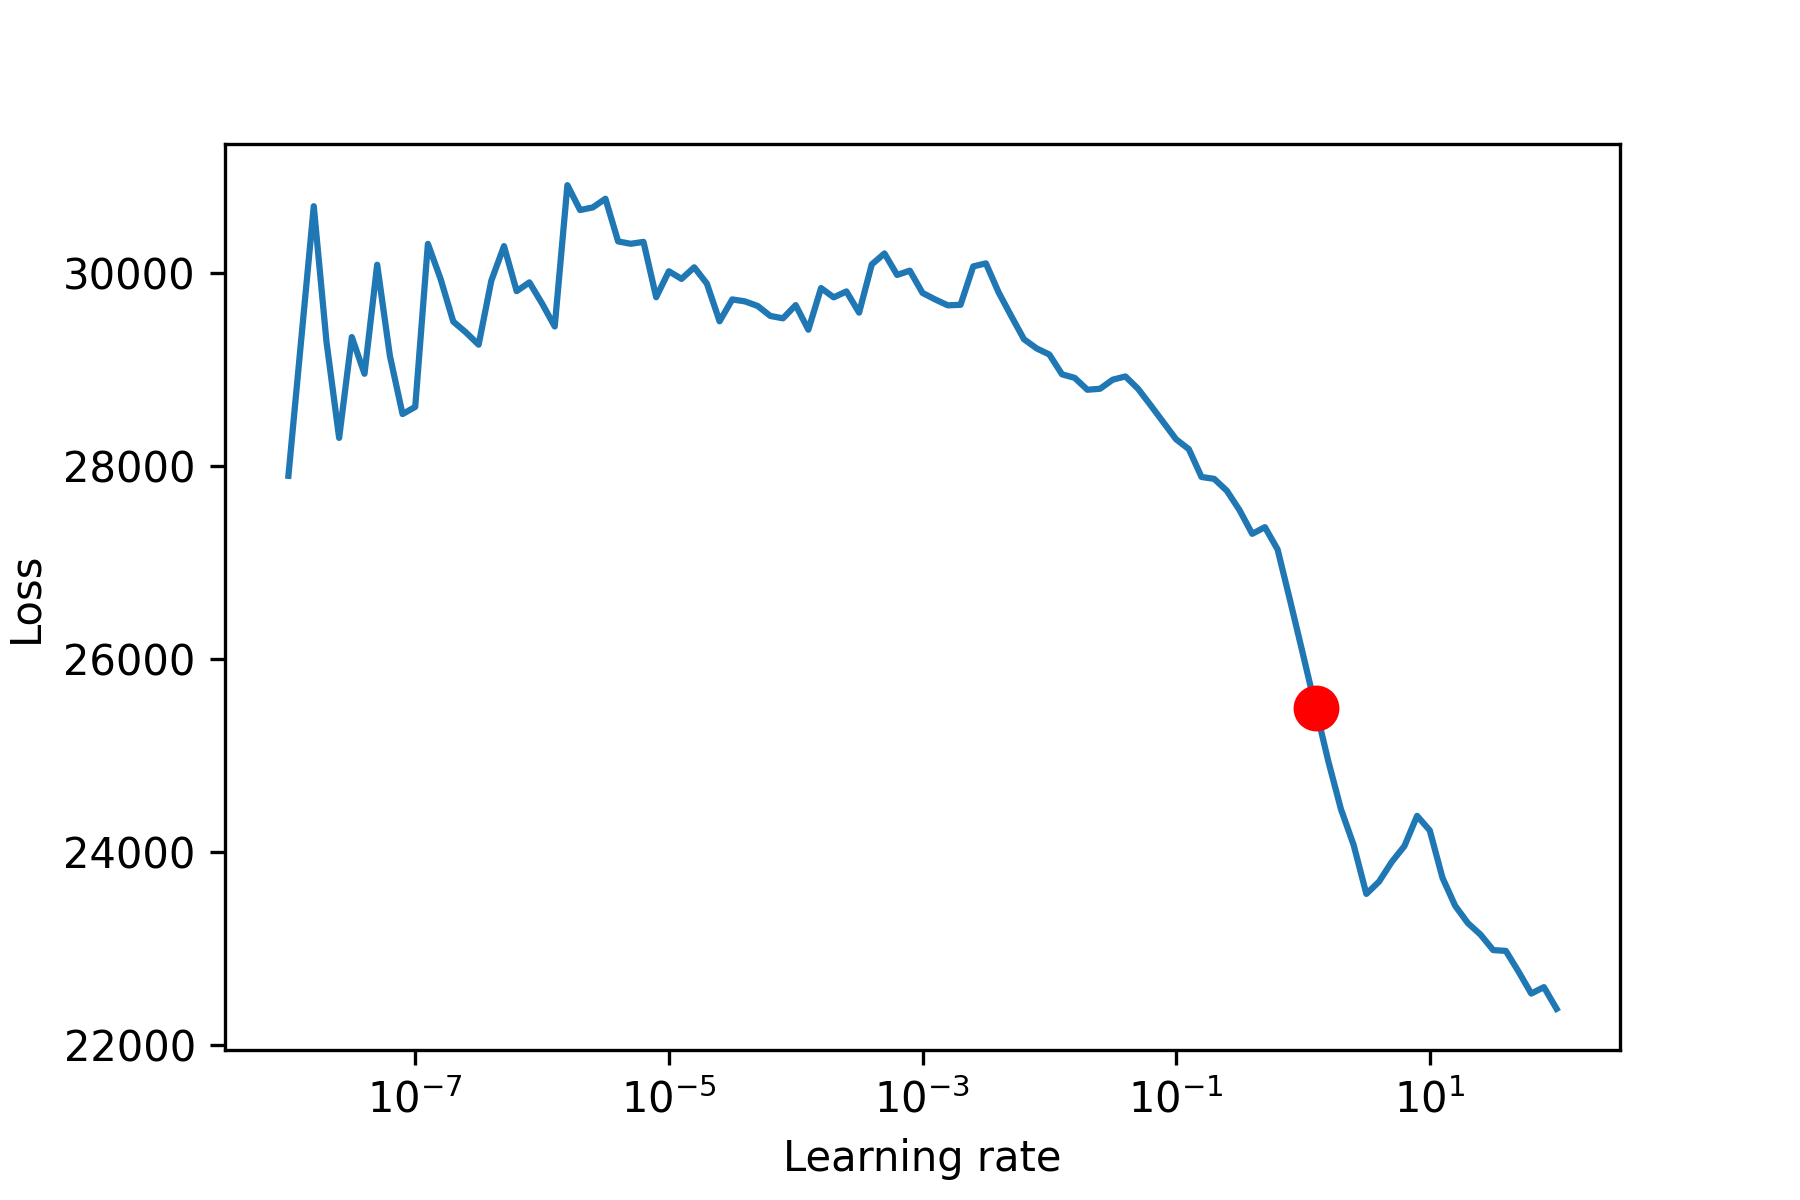

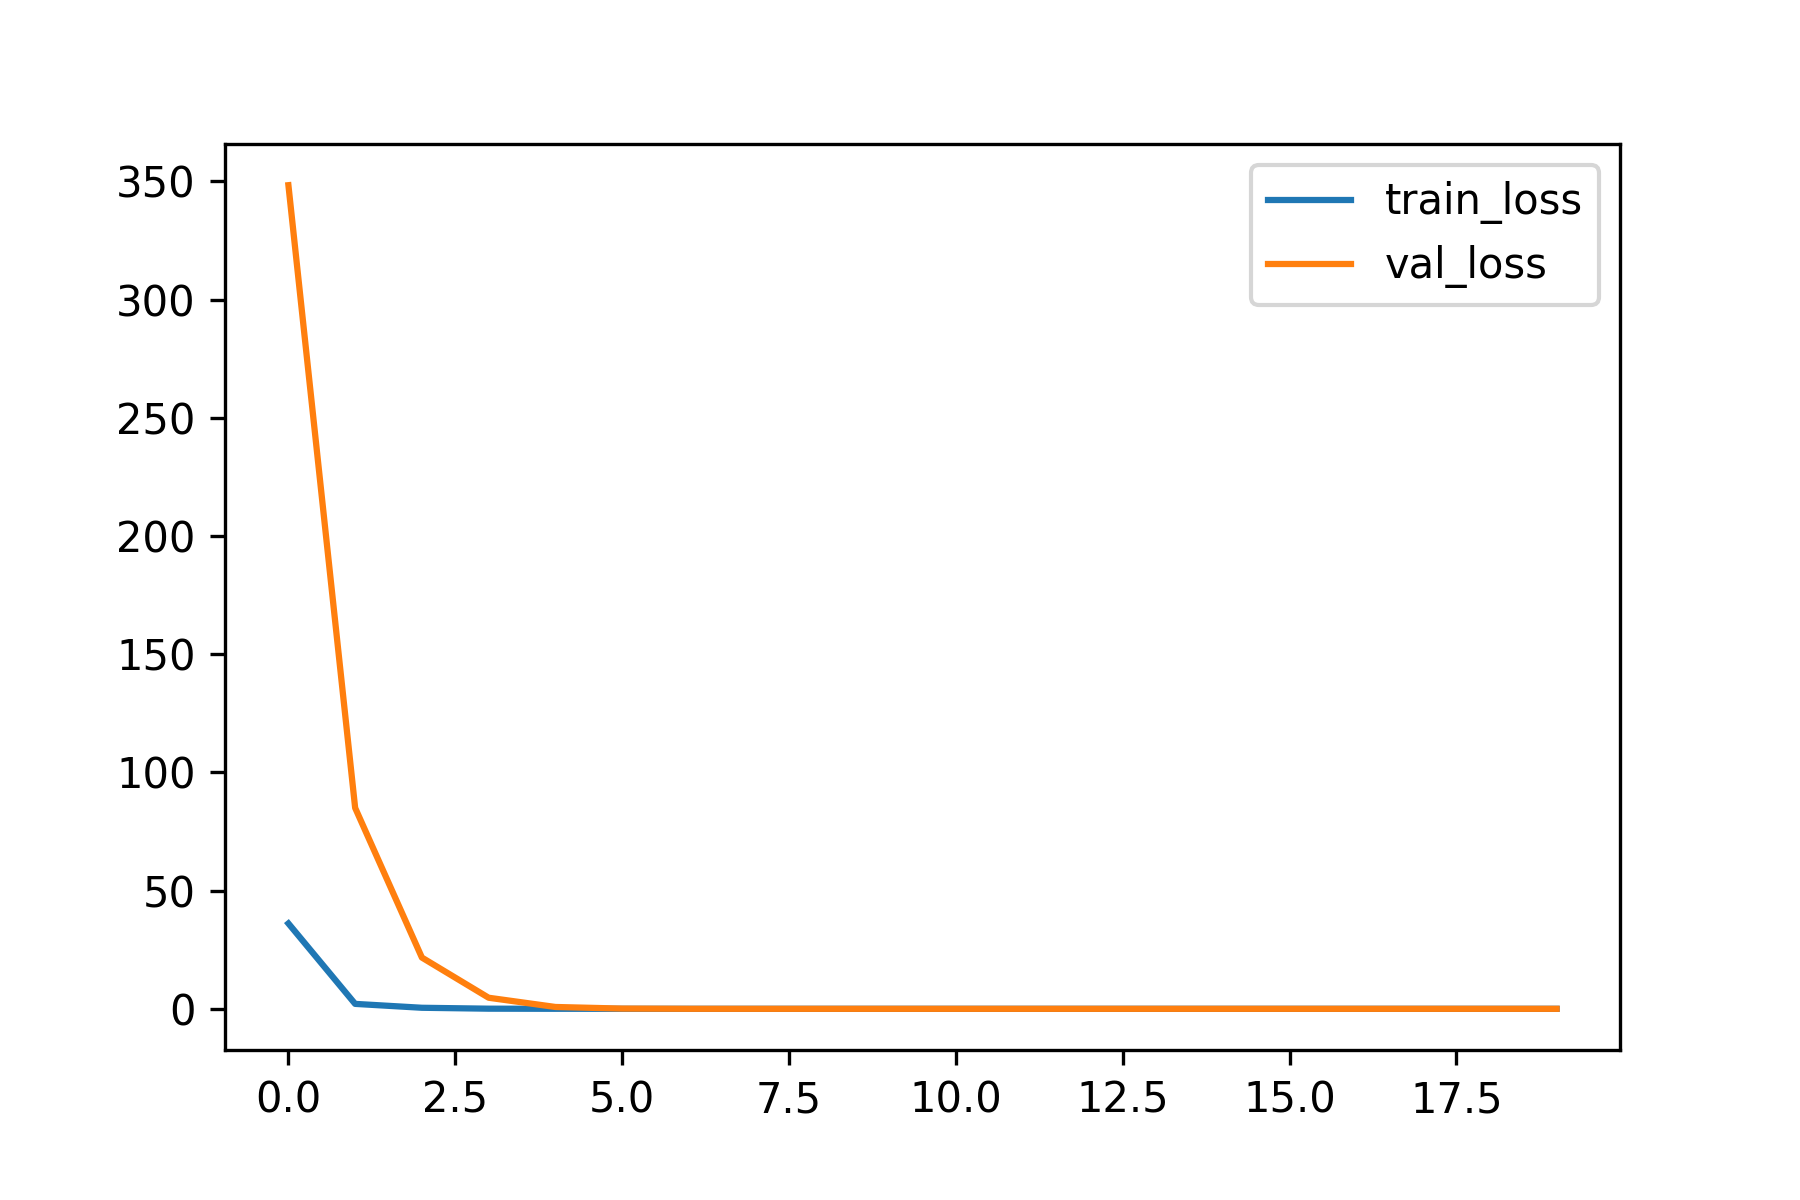

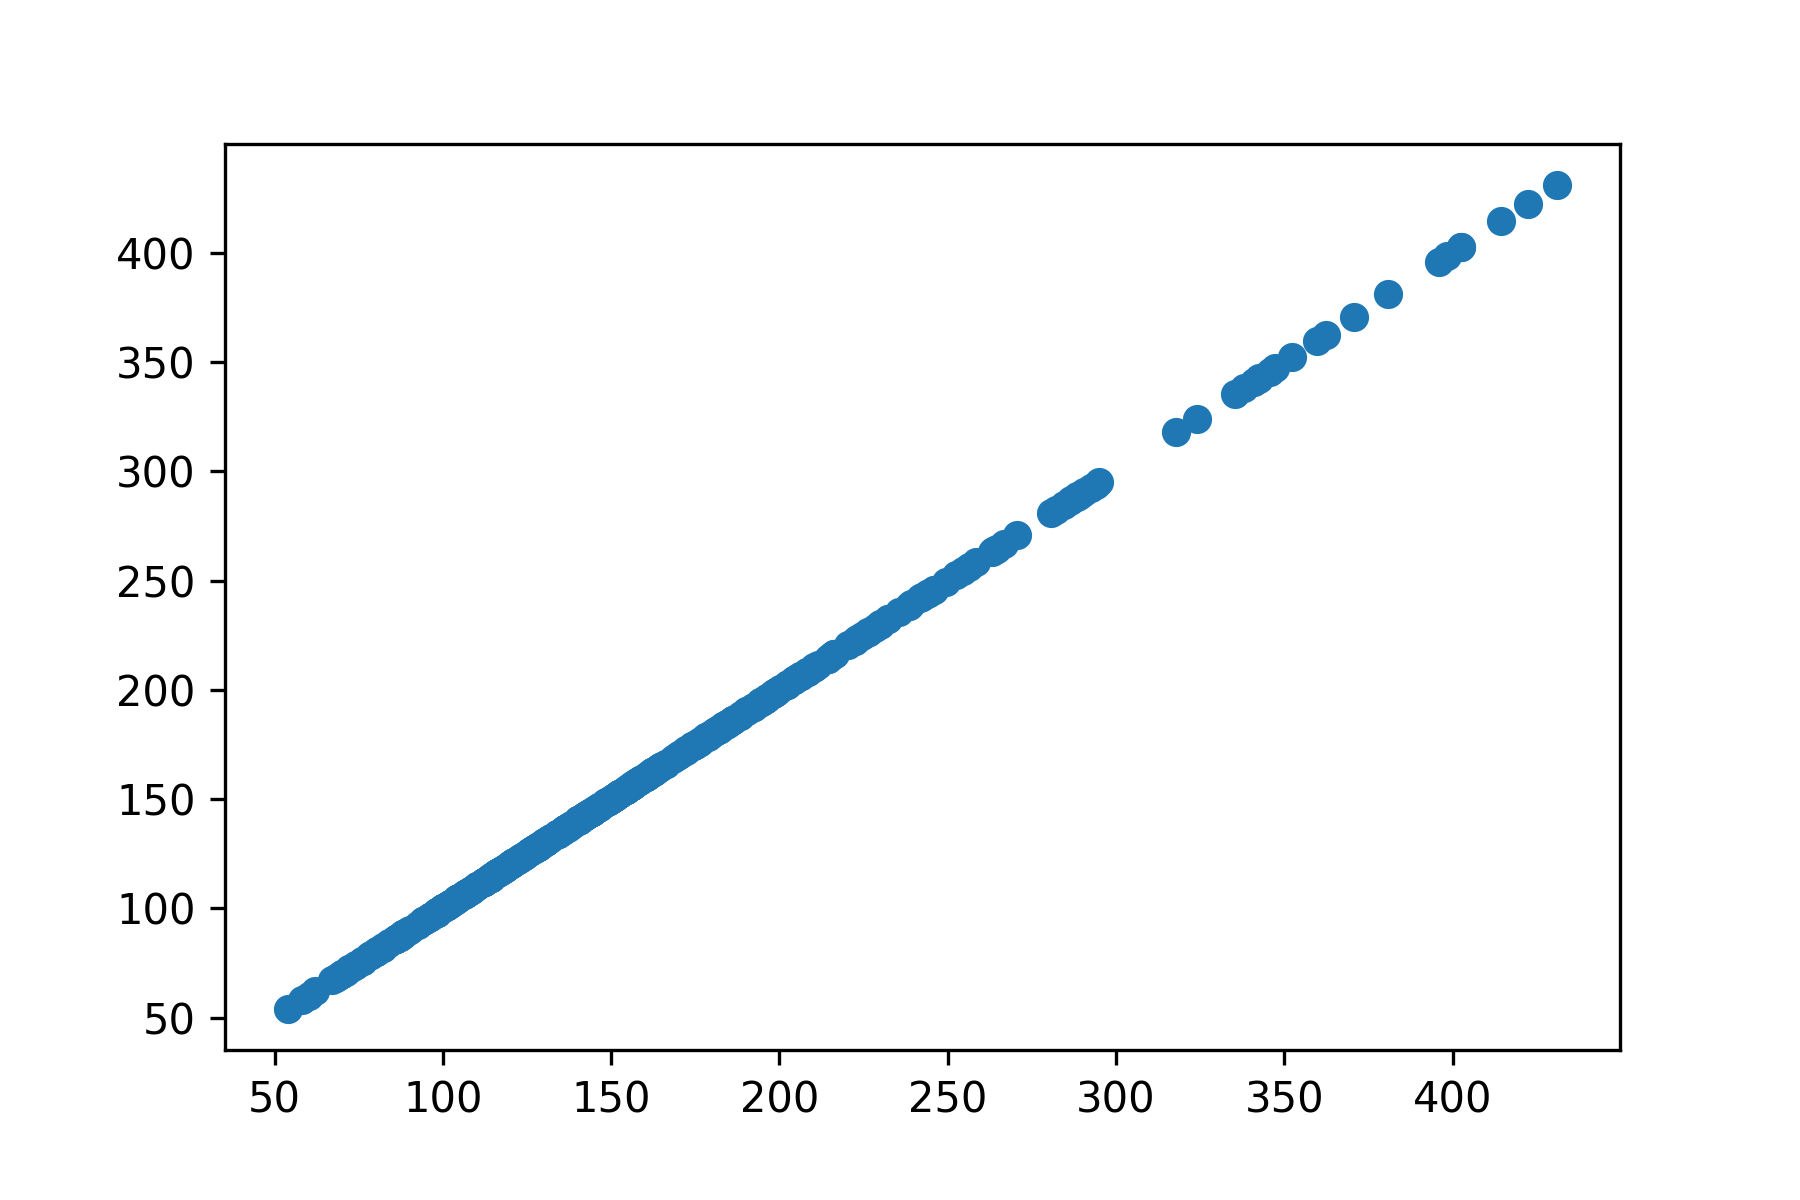

In [83]:
from molNet.featurizer.atom_featurizer import atom_symbol_one_hot
from torch_geometric.nn import GCNConv, GlobalAttention,global_add_pool
from molNet.nn.models.graph_convolution import PoolWeightedSum, PoolSum
import torch.nn.functional as F
import molNet.nn.functional as mF


class MolWeigtFromTypeModel(pl.LightningModule):
    def __init__(self,in_size,name="none"):
        super().__init__()
        self.save_hyperparameters()
        #self.gcn = GCNConv(in_channels=in_size,out_channels=1,bias=False)
        #gate_nn=torch.nn.Linear(in_size,1)
        self.pool_nn=torch.nn.Linear(in_size,1,bias=False)
        self.pooling =PoolWeightedSum(1)
        self.lr = 1e-1

    def unpacked_forward(self, feats, edges, batch,graph_features):
        #feats = self.gcn(feats, edges)
        #display(feats.shape,batch.shape)
        feats= self.pool_nn(feats)
        #display(feats.shape)
        feats = self.pooling(feats, batch)
        return feats

    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.graph_features)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def training_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss =  F.mse_loss(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss =  F.mse_loss(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('val_loss', loss)
        return loss
    
    def test_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss =  F.mse_loss(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('test_loss', loss)
        return loss
            
loader = PytorchGeomMolGraphFromDfLoader(dataset,smiles_column='SMILES',additional_data=['name'],#"all",
                                     y_properties=["molar_mass"],
                                     seed=2,
                                     to_graph_params={"atom_featurizer":atom_symbol_one_hot,"with_mol_graph":True},
                                    batch_size=32,#num_workers=4
                                    )
model = MolWeigtFromTypeModel(in_size=len(atom_symbol_one_hot))

model,data = default_model_run("MolWeigtFromTypeModel",model,loader,
                  force_run=True,#min_epochs=15
                
                 )


test_data=find_test_data(loader)
test_batch=iter(torch_geometric.data.DataLoader([test_data])).next()
#model.gcn(test_batch.x,test_batch.edge_index)
#model()

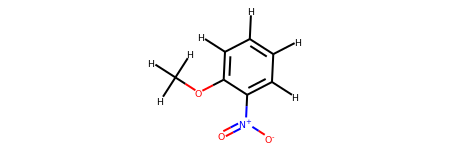

'153.13699340820312 vs 153.14076232910156'

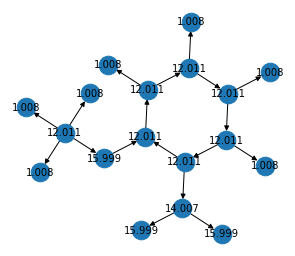

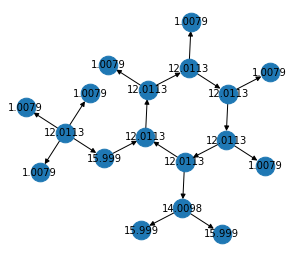

In [91]:
from rdkit.Chem.Draw import SimilarityMaps
display(test_data.mol_graph.mol)

#model.gcn.cached=True
prec=4

display("{} vs {}".format(test_data.y[0][0],model(test_batch)[0][0]))
target_graph = [atom.GetMass() for atom in test_data.mol_graph.mol.GetAtoms()]
l = [np.format_float_positional(c,precision=prec) for c in target_graph]
display(Image(test_data.mol_graph.get_png(labels=l)))

conv = test_batch.x.detach().numpy()#.flatten()
conv=np.argmax(conv,axis=1)
conv = model.pool_nn.weight[0][conv].detach().numpy()
l = [np.format_float_positional(c,precision=prec) for c in conv]
display(Image(test_data.mol_graph.get_png(labels=l)))



In [ ]:
# edge_index, edge_weight = model.gcn._cached_edge_index
x = torch.matmul(test_batch.x, model.gcn.weight)
x =  torch.matmul(test_batch.x, model.gcn.weight)
size = model.gcn.__check_input__(edge_index, None)

coll_dict = model.gcn.__collect__(model.gcn.__user_args__, edge_index, size,{})
coll_dict
#edge_weight.view(-1, 1)*x[1]

In [17]:
in_feat_titles = test_data.atom_featurizer.describe_features()
feat_weights = list(model.gcn.parameters())[0].detach().numpy()[:,0]
for i in range(feat_weights.shape[0]):
    print(in_feat_titles[i],feat_weights[i])
#for parameter in model.gcn.parameters():
#    print(parameter,len(parameter))

atom_symbol_one_hot: O 16.87843
atom_symbol_one_hot: Si 0.0
atom_symbol_one_hot: Al 0.0
atom_symbol_one_hot: Fe 0.0
atom_symbol_one_hot: Ca 0.0
atom_symbol_one_hot: Na 0.0
atom_symbol_one_hot: Mg 0.11842513
atom_symbol_one_hot: K 0.052285105
atom_symbol_one_hot: Ti 0.19796944
atom_symbol_one_hot: H 1.2811314
atom_symbol_one_hot: P 30.787542
atom_symbol_one_hot: Mn 0.17692792
atom_symbol_one_hot: F 23.785917
atom_symbol_one_hot: Sr 0.23515156
atom_symbol_one_hot: S 29.181076
atom_symbol_one_hot: C 10.022089
atom_symbol_one_hot: Zr 0.219336
atom_symbol_one_hot: Cl 42.43639
atom_symbol_one_hot: V 0.0
atom_symbol_one_hot: Cr 0.1335409
atom_symbol_one_hot: Rb 0.20966569
atom_symbol_one_hot: Ni 0.13364616
atom_symbol_one_hot: Zn 0.0
atom_symbol_one_hot: Cu 0.102247715
atom_symbol_one_hot: Y 0.105570614
atom_symbol_one_hot: Co 0.22765929
atom_symbol_one_hot: Sc 0.11155236
atom_symbol_one_hot: Li 0.0
atom_symbol_one_hot: Nb 0.0
atom_symbol_one_hot: N 13.584302
atom_symbol_one_hot: Ga 0.1015662

In [15]:
TEST_SMILES

'[H][H]'